# Lab 04: Ames Iowa Home Prices

---
author: Qiran Hu
date: October 4, 2024
embed-resources: true
---

## Introduction

## Methods

In [1]:
#import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_friedman1
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import accuracy_score, root_mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_friedman1
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_text
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.datasets import make_blobs
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor
from sklearn.metrics import make_scorer, mean_absolute_percentage_error
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_percentage_error

### Data

In [2]:
# load data
ames_train = pd.read_csv(
    "https://cs307.org/lab-04/data/ames-train.csv",
)
ames_test = pd.read_csv(
    "https://cs307.org/lab-04/data/ames-test.csv",
)

In [3]:
ames_train

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,2832,908188140,160,RM,24.0,2522,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2006,WD,Normal,137500
1,2736,905426150,80,RL,NaN,19690,Pave,NaN,IR1,Lvl,...,738,Gd,GdPrv,NaN,0,8,2006,WD,Alloca,274970
2,2135,907200130,20,RL,97.0,11800,Pave,NaN,IR1,Bnk,...,0,NaN,NaN,NaN,0,8,2007,WD,Family,131000
3,2424,528228415,120,RM,NaN,3072,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,5,2006,WD,Normal,178740
4,1967,535457020,20,RL,80.0,8000,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,11,2007,WD,Normal,156500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1870,1020,527302070,20,RL,NaN,10825,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,7,2008,WD,Normal,181900
1871,237,905426200,20,RL,65.0,11479,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,144500
1872,1547,910202050,30,RM,40.0,3636,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,1,2008,WD,Normal,55000
1873,1855,533251110,20,RL,80.0,12000,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,3,2007,WD,Normal,255000


In [4]:
# summary statistics
ames_train.shape[0]

1875

In [5]:
ames_train.shape[1]

82

In [6]:
# visualizations
# create X and y for train dataset
X_train = ames_train.drop("SalePrice", axis=1)
y_train = ames_train["SalePrice"]

# create X and y for test dataset
X_test = ames_test.drop("SalePrice", axis=1)
y_test = ames_test["SalePrice"]

In [7]:
numeric_features = X_train.select_dtypes(include=["int64", "float64"]).columns
categorical_features = X_train.select_dtypes(include=["object", "category"]).columns

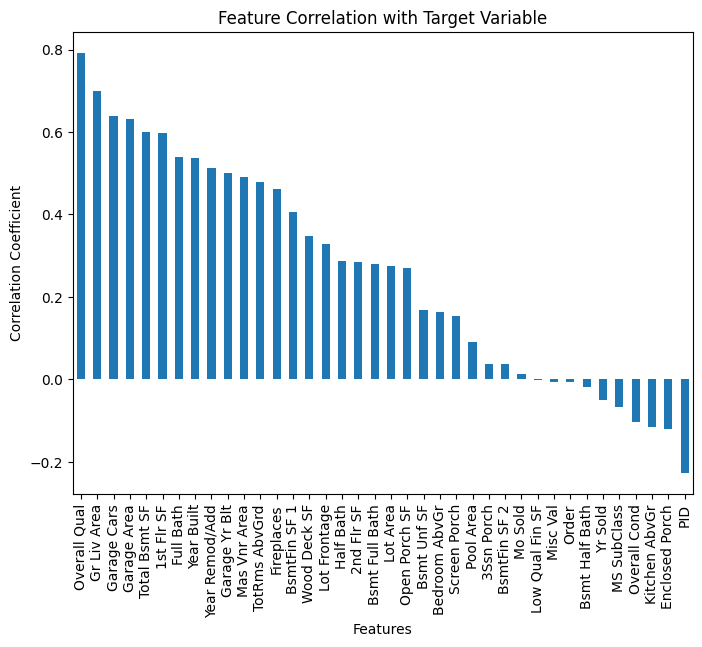

In [8]:
X_numeric = X_train[numeric_features]
data_numeric = pd.concat([X_numeric, y_train], axis=1)
corr_matrix = data_numeric.corr()
target_corr = corr_matrix['SalePrice'].drop('SalePrice')
plt.figure(figsize=(8, 6))
target_corr.sort_values(ascending=False).plot(kind='bar')
plt.title('Feature Correlation with Target Variable')
plt.ylabel('Correlation Coefficient')
plt.xlabel('Features')
plt.show()

In [9]:
threshold = 0.3
selected_features_numeric = target_corr[(target_corr) >= threshold].index.tolist()
selected_features_numeric

['Lot Frontage',
 'Overall Qual',
 'Year Built',
 'Year Remod/Add',
 'Mas Vnr Area',
 'BsmtFin SF 1',
 'Total Bsmt SF',
 '1st Flr SF',
 'Gr Liv Area',
 'Full Bath',
 'TotRms AbvGrd',
 'Fireplaces',
 'Garage Yr Blt',
 'Garage Cars',
 'Garage Area',
 'Wood Deck SF']

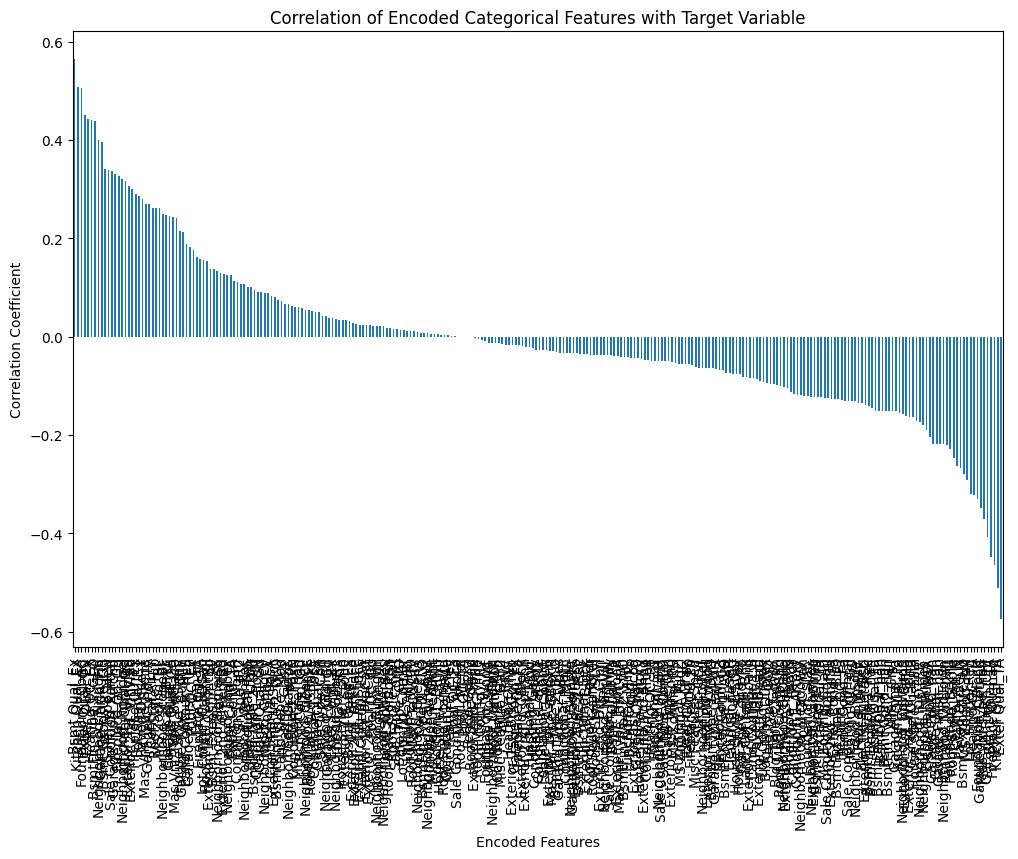

In [10]:
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_train_encoded = ohe.fit_transform(X_train[categorical_features])
encoded_columns = ohe.get_feature_names_out(categorical_features)
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoded_columns, index=X_train.index)
data_encoded = pd.concat([X_train_encoded_df, y_train], axis=1)
corr_matrix = data_encoded.corr()
target_corr = corr_matrix['SalePrice'].drop('SalePrice')
plt.figure(figsize=(12, 8))
target_corr.sort_values(ascending=False).plot(kind='bar')
plt.title('Correlation of Encoded Categorical Features with Target Variable')
plt.ylabel('Correlation Coefficient')
plt.xlabel('Encoded Features')
plt.show()

In [11]:
threshold = 0.4
selected_features_categorical1 = target_corr[(target_corr) >= threshold].index.tolist()
selected_features_categorical1

['Neighborhood_NridgHt',
 'Exter Qual_Ex',
 'Exter Qual_Gd',
 'Foundation_PConc',
 'Bsmt Qual_Ex',
 'BsmtFin Type 1_GLQ',
 'Heating QC_Ex',
 'Kitchen Qual_Ex']

In [12]:
#selected_features_categorical = ["Neighborhood", "Exterior 1st", "Exterior 2nd", "Exter Qual", "Foundation", "Bsmt Qual", "BsmtFin Type 1", "Kitchen Qual", "Heating QC", "Garage Finish", "Fireplace Qu", "Garage Type"]
#selected_features_categorical = ["Neighborhood", "Exter Qual", "Foundation", "Bsmt Qual", "BsmtFin Type 1", "Heating QC", "Kitchen Qual", "Garage Type"]
#selected_features_categorical = ["Foundation", "Bsmt Qual", "Kitchen Qual"]
#selected_features_categorical


In [13]:
# helper function to find columns that are mostly missing
def columns_missing_above_threshold(df, threshold):
    missing_proportion = df.isnull().sum() / len(df)
    columns_above_threshold = missing_proportion[missing_proportion > threshold].index.tolist()
    return columns_above_threshold

In [14]:
# define columns to be excluded
many_missing_columns = columns_missing_above_threshold(X_train, 0.6)
exclude_columns = ["Order", "PID"] + many_missing_columns

# find columns with string data type (will be considered categorical)
string_columns = X_train.select_dtypes(include=["object"]).columns.tolist()
string_columns = [col for col in string_columns if col not in exclude_columns]

# find columns with numeric data type
numeric_columns = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
numeric_columns = [col for col in numeric_columns if col not in exclude_columns]

### Models

In [18]:
# pipeline for numeric
numeric_preprocessor = Pipeline(
    steps=[
        ("MedianImputer", SimpleImputer(strategy="median")),
        ("Standardize", StandardScaler()),
    ]
)

# pipeline for categorical
categorical_preprocessor = Pipeline(
    steps=[
        ("ModalImputer", SimpleImputer(strategy="most_frequent")),
        ("OneHotEncoder", OneHotEncoder(handle_unknown="infrequent_if_exist", max_categories=5)),
    ]
)

# column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ("ExcludeColumns", "drop", exclude_columns),
        ("CategoricalPreprocessing", categorical_preprocessor, string_columns),
        ("NumericProcessing", numeric_preprocessor, numeric_columns),
    ],
    remainder="drop",
)

# full pipeline
pipeline = Pipeline(
    steps=[
        ("Preprocessor", preprocessor),
        ("Regressor", DummyRegressor()),
    ]
)
param_grid = [
    {
        "Regressor": [DummyRegressor()],
    },
    {
        "Regressor": [LinearRegression()],
    },
    {
        "Regressor": [KNeighborsRegressor()],
        "Regressor__n_neighbors": [1, 3, 5, 7, 9, 11, 15],
    },
    {
        "Regressor": [DecisionTreeRegressor()],
        "Regressor__max_depth": [1, 3, 5, 7, 9, 11, 15, None],
    },
    {
        "Regressor": [HistGradientBoostingRegressor()],
        "Regressor__learning_rate": [0.1, 0.01, 0.001],
        "Regressor__max_iter": [1000],
        "Regressor__max_depth": [None, 3],
        "Regressor__l2_regularization": [0.1, 1.0],
    },
]

In [19]:
mod = GridSearchCV(pipeline, param_grid, n_jobs = -1, cv = 5, verbose = 2, scoring='neg_mean_absolute_percentage_error')
mod.fit(X_train, y_train)

Fitting 5 folds for each of 29 candidates, totalling 145 fits


[CV] END .........................Regressor=DummyRegressor(); total time=   0.2s
[CV] END .........................Regressor=DummyRegressor(); total time=   0.2s
[CV] END .........................Regressor=DummyRegressor(); total time=   0.2s
[CV] END .........................Regressor=DummyRegressor(); total time=   0.2s
[CV] END .........................Regressor=DummyRegressor(); total time=   0.2s
[CV] END .......................Regressor=LinearRegression(); total time=   0.3s
[CV] END .......................Regressor=LinearRegression(); total time=   0.3s
[CV] END .......................Regressor=LinearRegression(); total time=   0.3s
[CV] END .......................Regressor=LinearRegression(); total time=   0.2s
[CV] END .......................Regressor=LinearRegression(); total time=   0.3s
[CV] END Regressor=KNeighborsRegressor(), Regressor__n_neighbors=1; total time=   0.3s
[CV] END Regressor=KNeighborsRegressor(), Regressor__n_neighbors=1; total time=   0.2s
[CV] END Regress

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Preprocessor',
                                        ColumnTransformer(transformers=[('ExcludeColumns',
                                                                         'drop',
                                                                         ['Order',
                                                                          'PID',
                                                                          'Alley',
                                                                          'Pool '
                                                                          'QC',
                                                                          'Fence',
                                                                          'Misc '
                                                                          'Feature']),
                                                                        ('CategoricalPreprocessing',
                                                                         Pipeline(steps=[('ModalImputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('OneHotEncoder',
                                                                                          OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                                                        max_...
                          'Regressor__n_neighbors': [1, 3, 5, 7, 9, 11, 15]},
                         {'Regressor': [DecisionTreeRegressor()],
                          'Regressor__max_depth': [1, 3, 5, 7, 9, 11, 15,
                                                   None]},
                         {'Regressor': [HistGradientBoostingRegressor()],
                          'Regressor__l2_regularization': [0.1, 1.0],
                          'Regressor__learning_rate': [0.1, 0.01, 0.001],
                          'Regressor__max_depth': [None, 3],
                          'Regressor__max_iter': [1000]}],
             scoring='neg_mean_absolute_percentage_error', verbose=2)

In [20]:
y_pred = mod.best_estimator_.predict(X_test)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"Test MAPE: {mape}")

Test MAPE: 0.08164649164771304


In [21]:
-mod.best_score_

np.float64(0.09323748138117231)

## Results

In [22]:
# report model metrics
from joblib import dump
dump(mod, "ames-housing.joblib")

['ames-housing.joblib']

## Discussion

### Conclusion